# Ternary plots for vanilla classifiers

In [1]:
import os
import sys
import time
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from scipy import stats
from scipy.special import softmax
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense

from utils.ops import onehot_encode
from utils.data import get_cifar3, get_cifarn
from utils.metrics import neg_log_likelihood, accuracy
from utils.visualization import plot_pdf_triplex, plot_prob_triplex
from calibrators import PAVCalibrator, NiceCalibrator, TempScalingCalibrator

In [2]:
%matplotlib inline

## Load IRIS dataset

In [3]:
iris = load_iris()
ix2label = {
    0: 'Setosa',
    1: 'Versicolour',
    2: 'Virginica'}

There are 50 samples per class, we can take 15 of each to form a validation set. Samples come ordered by class, the first 50 are class-0 samples, etc..

In [4]:
n_samples_class = 30

idxs0, idxs1, idxs2 = np.random.permutation(50), np.random.permutation(50)+50, np.random.permutation(50)+100

X_train = np.vstack((iris.data[idxs0[:n_samples_class], :],
                     iris.data[idxs1[:n_samples_class], :],
                     iris.data[idxs2[:n_samples_class], :]))
y_train = np.hstack((iris.target[idxs0[:n_samples_class]], iris.target[idxs1[:n_samples_class]], iris.target[idxs2[:n_samples_class]]))

X_test = np.vstack((iris.data[idxs0[n_samples_class:], :],
                    iris.data[idxs1[n_samples_class:], :],
                    iris.data[idxs2[n_samples_class:], :]))
y_test = np.hstack((iris.target[idxs0[n_samples_class:]], iris.target[idxs1[n_samples_class:]], iris.target[idxs2[n_samples_class:]]))

### Train a SVM

In [5]:
svc = SVC(kernel='rbf', probability=True);
svc.fit(X_train, y_train);

C:\Users\sergi\Anaconda3\envs\famarch\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [6]:
# Performance
print("Accuracy: {:.3f}".format(svc.score(X_train, y_train)))
print("Accuracy on the test set: {:.3f}".format(svc.score(X_test, y_test)))

probs = svc.predict_proba(X_train)
probs_test = svc.predict_proba(X_test)
print("Cross-entropy: {:.3f}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {:.3f}".format(neg_log_likelihood(probs_test, y_test)))

Accuracy: 0.989
Accuracy on the test set: 0.983
Cross-entropy: 0.074
Cross-entropy on the test set: 0.129


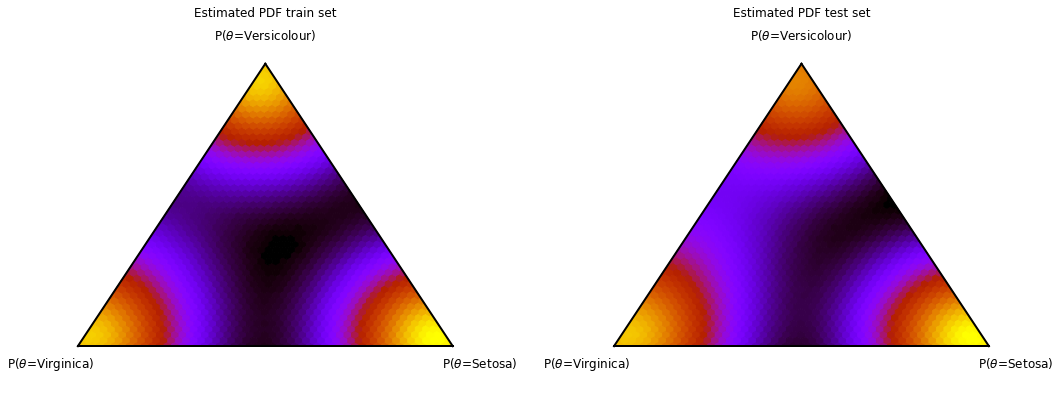

In [7]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_triplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_triplex(probs_test, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

### Temperature Scaling effects 

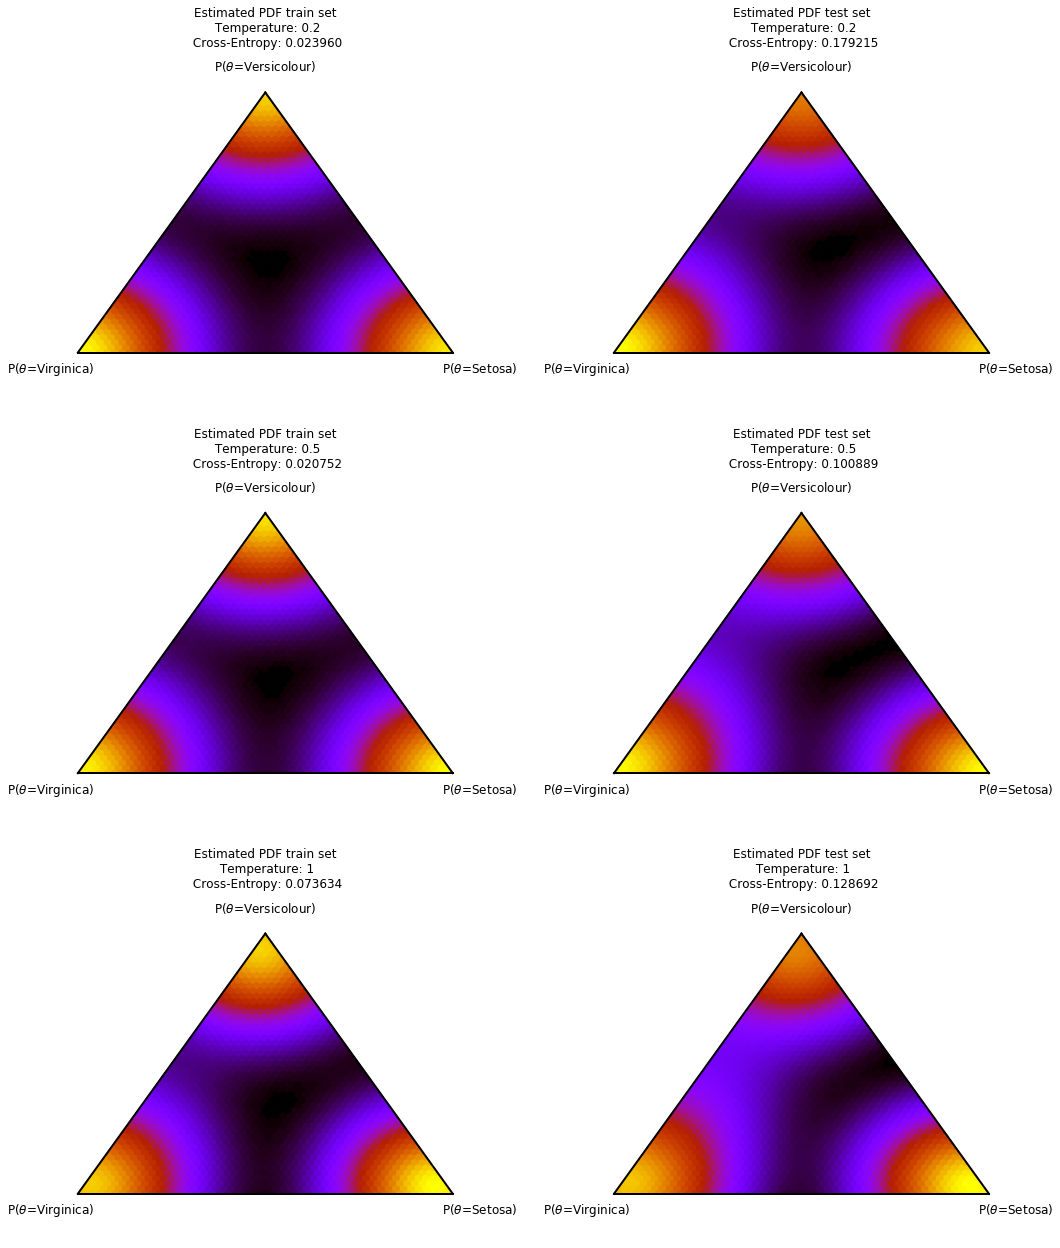

In [8]:
train_logits = svc.predict_log_proba(X_train)
test_logits = svc.predict_log_proba(X_test)

Ts = [0.2, 0.5, 1]
fig, ax_arr = plt.subplots(len(Ts), 2, figsize=(17, 7*len(Ts)), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

for i, T in enumerate(Ts):
    train_probs = softmax(train_logits/T, axis=1)
    test_probs = softmax(test_logits/T, axis=1)
    train_xentropy = neg_log_likelihood(train_probs, y_train)
    test_xentropy = neg_log_likelihood(test_probs, y_test)
    
    ax_arr[i, 0] = plot_pdf_triplex(train_probs, ax=ax_arr[i, 0],
                                 title='Estimated PDF train set\n Temperature: {}\n Cross-Entropy: {:3f}'.format(T, train_xentropy),
                                 fontsize=12, labels=list(ix2label.values()));
    ax_arr[i, 1] = plot_pdf_triplex(test_probs, ax=ax_arr[i, 1],
                                 title='Estimated PDF test set\n Temperature: {}\n Cross-Entropy: {:3f}'.format(T, test_xentropy),
                                 fontsize=12, labels=list(ix2label.values()));
plt.show()

### Optimum temperature

In [3]:
def optim_temperature(logits, target, min_diff=1e-5, step=0.1):
    T = 1.0
    probs = softmax(logits/T, axis=1)

    while True:
        # Compute gradient w.r.t. T
        one_hot = onehot_encode(target)
        grad = -np.mean(np.sum((probs-one_hot)*logits/T**2, axis=1))

        # Update step
        probs_new = softmax(logits/(T-grad*step), axis=1)

        if abs(grad*step) < min_diff:
            break

        T -= grad*step
        probs = probs_new

    return T

In [10]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 0.366
 achieves LNN=0.116 on test set
Optimum temperature for test set: 0.612
 achieves LNN=0.098 on test set


### Load CIFAR-3

In [4]:
data_path = '../cifar-10'
cifar3, ix2label = get_cifarn(data_path, target_labels=['airplane', 'automobile', 'bird'], test=True,
                              prior=[0.5, 0.2, 0.3], test_prior=[0.3, 0.5, 0.2])

### Train a simple classifier: PCA+Logistic

In [5]:
# Hyperparameters
n_components = 20

In [6]:
# Prepare data
y_train = cifar3['labels']
X_train = np.array([ima.flatten() for ima in cifar3['images']])

y_test = cifar3['test_labels']
X_test = np.array([ima.flatten() for ima in cifar3['test_images']])

In [14]:
# Fit PCA
pca = PCA(n_components=n_components, svd_solver='randomized',whiten=True).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [15]:
# Train LogisticRegression
t0 = time.time()
logistic = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(X_train_pca, y_train)
print("Fitted in {:.3f}s".format(time.time() - t0))

Fitted in 0.066s


In [16]:
# Train and test performance
print("Accuracy on the train set: {}".format(logistic.score(X_train_pca, y_train)))
print("Accuracy on the test set: {}".format(logistic.score(X_test_pca, y_test)))

probs = logistic.predict_proba(X_train_pca)
test_probs = logistic.predict_proba(X_test_pca)
print("Cross-entropy on the train set: {}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.7059
Accuracy on the test set: 0.6405
Cross-entropy on the train set: 0.7300430711691979
Cross-entropy on the test set: 0.8609746672664812


## Visualizing results 

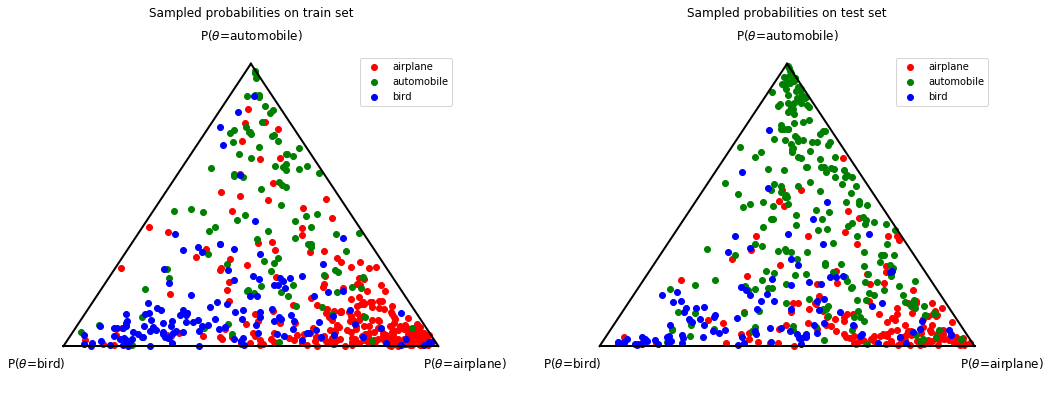

In [17]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_prob_triplex(probs[:500], target=y_train[:500], ax=ax_arr[0],
                              title='Sampled probabilities on train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_prob_triplex(test_probs[:500], target=y_test[:500], ax=ax_arr[1],
                              title='Sampled probabilities on test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

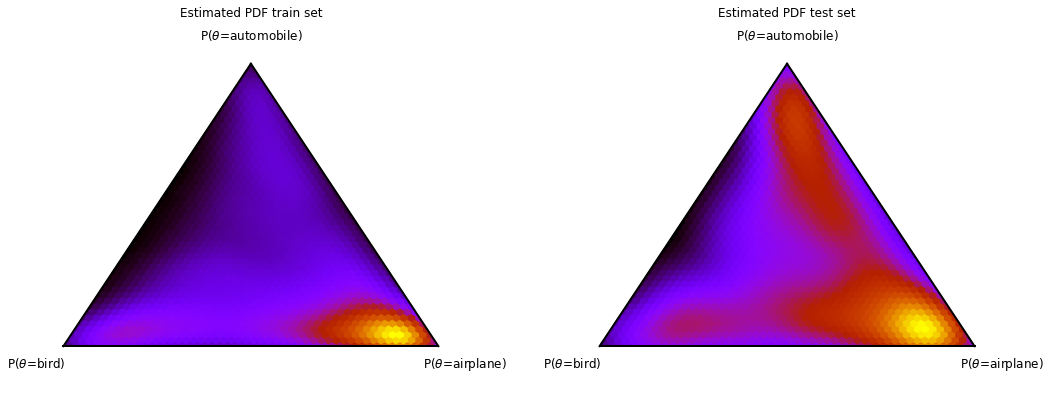

In [18]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_triplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_triplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

### Temperature Scaling effects

In [19]:
train_logits = logistic.predict_log_proba(X_train_pca)
test_logits = logistic.predict_log_proba(X_test_pca)

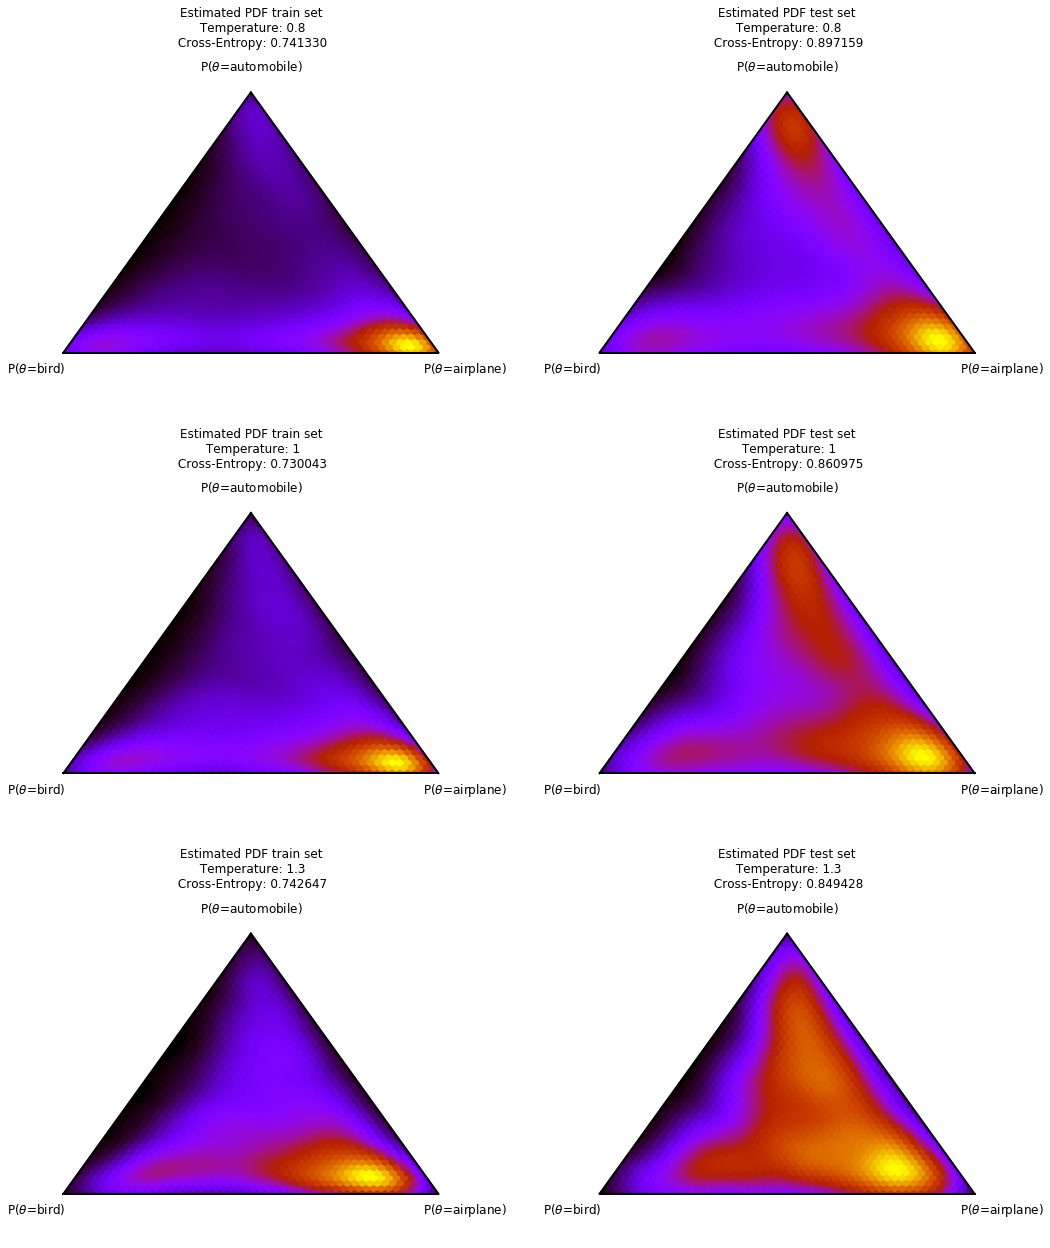

In [20]:
Ts = [0.8, 1, 1.3]
fig, ax_arr = plt.subplots(len(Ts), 2, figsize=(17, 7*len(Ts)), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

for i, T in enumerate(Ts):
    train_probs = softmax(train_logits/T, axis=1)
    test_probs = softmax(test_logits/T, axis=1)
    train_xentropy = neg_log_likelihood(train_probs, y_train)
    test_xentropy = neg_log_likelihood(test_probs, y_test)
    
    ax_arr[i, 0] = plot_pdf_triplex(train_probs, ax=ax_arr[i, 0],
                                 title='Estimated PDF train set\n Temperature: {}\n Cross-Entropy: {:3f}'.format(T, train_xentropy),
                                 fontsize=12, labels=list(ix2label.values()));
    ax_arr[i, 1] = plot_pdf_triplex(test_probs, ax=ax_arr[i, 1],
                                 title='Estimated PDF test set\n Temperature: {}\n Cross-Entropy: {:3f}'.format(T, test_xentropy),
                                 fontsize=12, labels=list(ix2label.values()));
plt.show()

In [21]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 0.999
 achieves LNN=0.861 on test set
Optimum temperature for test set: 1.277
 achieves LNN=0.849 on test set


## PCA + SVMLinear

In [22]:
# Train SVM
t0 = time.time()
svc = SVC(kernel='linear', probability=True);
svc.fit(X_train_pca, y_train);
print("Fitted in {:.3f}s".format(time.time() - t0))

Fitted in 35.038s


In [23]:
# Train and test performance
print("Accuracy on the train set: {}".format(svc.score(X_train_pca, y_train)))
print("Accuracy on the test set: {}".format(svc.score(X_test_pca, y_test)))

probs = svc.predict_proba(X_train_pca)
test_probs = svc.predict_proba(X_test_pca)
print("Cross-entropy on the train set: {}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.7093
Accuracy on the test set: 0.645
Cross-entropy on the train set: 0.7296014695830376
Cross-entropy on the test set: 0.8630525999551067


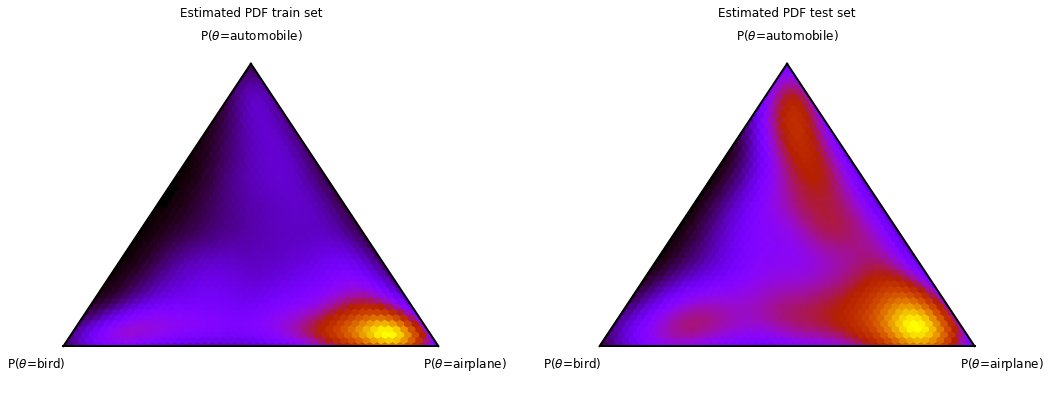

In [24]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_triplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_triplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

In [25]:
train_logits = svc.predict_log_proba(X_train_pca)
test_logits = svc.predict_log_proba(X_test_pca)

In [26]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 0.961
 achieves LNN=0.867 on test set
Optimum temperature for test set: 1.246
 achieves LNN=0.854 on test set


## PCA + SVMPolynomial

In [27]:
# Train SVM
t0 = time.time()
svc_poly = SVC(kernel='poly', degree=2, probability=True);
svc_poly.fit(X_train_pca, y_train);
print("Fitted in {:.3f}s".format(time.time() - t0))

C:\Users\sergi\Anaconda3\envs\famarch\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Fitted in 16.649s


In [28]:
# Train and test performance
print("Accuracy on the train set: {}".format(svc_poly.score(X_train_pca, y_train)))
print("Accuracy on the test set: {}".format(svc_poly.score(X_test_pca, y_test)))

probs = svc_poly.predict_proba(X_train_pca)
test_probs = svc_poly.predict_proba(X_test_pca)
print("Cross-entropy on the train set: {}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.7263
Accuracy on the test set: 0.6325
Cross-entropy on the train set: 0.677630958429691
Cross-entropy on the test set: 0.8342474115669343


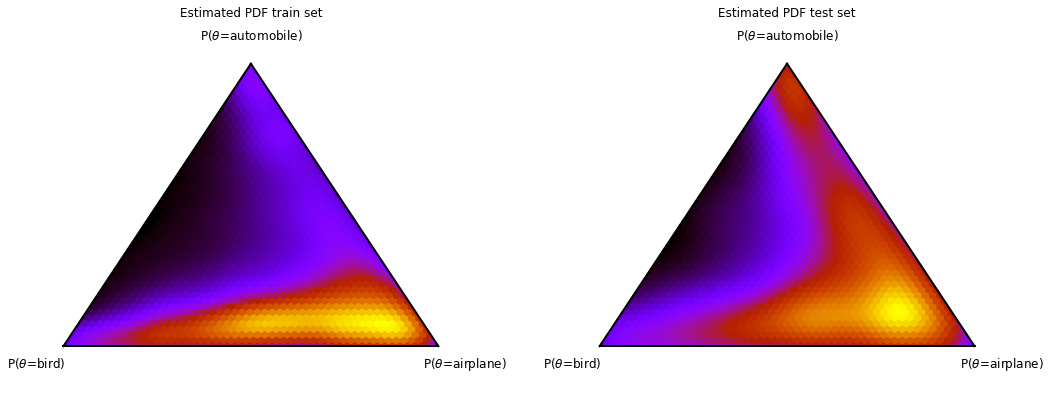

In [29]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_triplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_triplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

In [30]:
train_logits = svc_poly.predict_log_proba(X_train_pca)
test_logits = svc_poly.predict_log_proba(X_test_pca)

In [31]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 0.866
 achieves LNN=0.854 on test set
Optimum temperature for test set: 1.285
 achieves LNN=0.823 on test set


## PCA + SVMrbf 

In [32]:
# Train SVM
t0 = time.time()
svc_rbf = SVC(kernel='rbf', probability=True);
svc_rbf.fit(X_train_pca, y_train);
print("Fitted in {:.3f}s".format(time.time() - t0))

C:\Users\sergi\Anaconda3\envs\famarch\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Fitted in 17.941s


In [33]:
# Train and test performance
print("Accuracy on the train set: {}".format(svc_rbf.score(X_train_pca, y_train)))
print("Accuracy on the test set: {}".format(svc_rbf.score(X_test_pca, y_test)))

probs = svc_rbf.predict_proba(X_train_pca)
test_probs = svc_rbf.predict_proba(X_test_pca)
print("Cross-entropy on the train set: {}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.8624
Accuracy on the test set: 0.7655
Cross-entropy on the train set: 0.3820228438771471
Cross-entropy on the test set: 0.5752330640678959


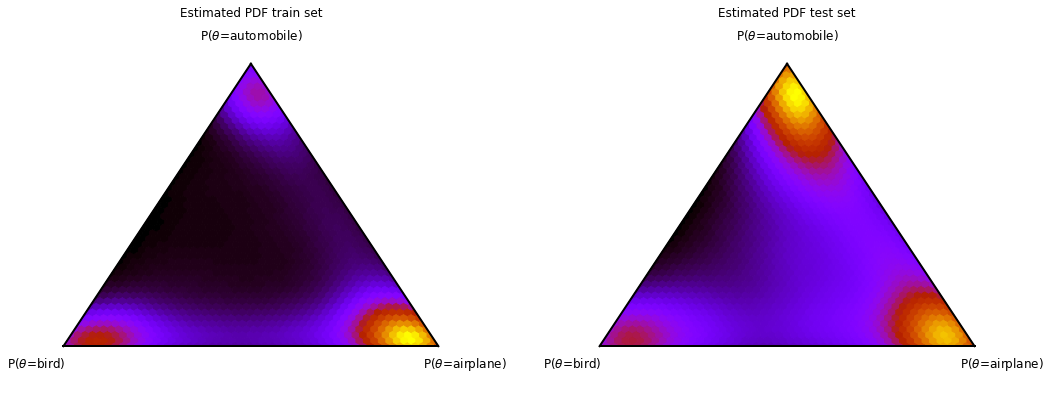

In [34]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_triplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_triplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

In [35]:
train_logits = svc_rbf.predict_log_proba(X_train_pca)
test_logits = svc_rbf.predict_log_proba(X_test_pca)

In [36]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 0.782
 achieves LNN=0.595 on test set
Optimum temperature for test set: 1.042
 achieves LNN=0.575 on test set


# SmallCNN

In [7]:
cnn_path = '../pretrained-models/cnn_cifar'

In [8]:
model = tf.keras.models.load_model(os.path.join(cnn_path, 'cnn_cifar.h5'), custom_objects={'tf': tf})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [9]:
# Compute predictions
train_probs = model.predict(cifar3['images']/255.)
test_probs = model.predict(cifar3['test_images']/255.)

In [10]:
# Train and test performance
print("Accuracy on the train set: {}".format(accuracy(train_probs, y_train)))
print("Accuracy on the test set: {}".format(accuracy(test_probs, y_test)))


print("Cross-entropy on the train set: {}".format(neg_log_likelihood(train_probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.8675
Accuracy on the test set: 0.853
Cross-entropy on the train set: 0.3523881295678235
Cross-entropy on the test set: 0.3672155252316079


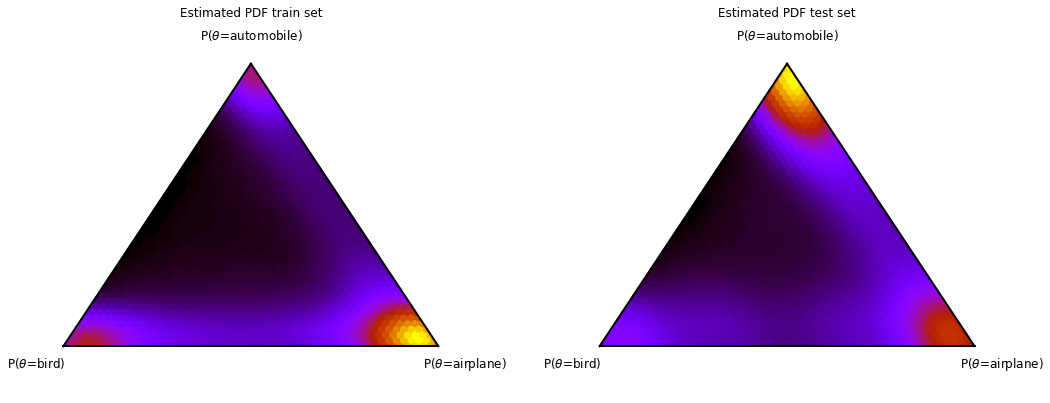

In [11]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_triplex(train_probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_triplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

## Calibrating cnn
### Obtain the logits

In [12]:
logits = np.log(model.predict(cifar3['test_images']/255.).astype(np.float))
target = onehot_encode(y_test.astype(np.int))

### Temperature Scaling 

In [13]:
# Temp scaling
t0 = time.time()
temp_cal = TempScalingCalibrator(logits, target)
print("Optimal temperature found: {:.3f}, elapsed time: {:.3f}s".format(temp_cal.T, (time.time()-t0)))
temp_probs = temp_cal.predict(logits)

temp_nll = neg_log_likelihood(temp_probs, target)
temp_acc = accuracy(temp_probs, target)

print("Negative log-likelihood after calibration with temp-scaling: {:.3f}".format(temp_nll))
print("Accuracy after calibration with temp-scaling: {:.3f}".format(temp_acc))

Optimal temperature found: 0.843, elapsed time: 0.023s
Negative log-likelihood after calibration with temp-scaling: 0.362
Accuracy after calibration with temp-scaling: 0.853


Effect on simplex:

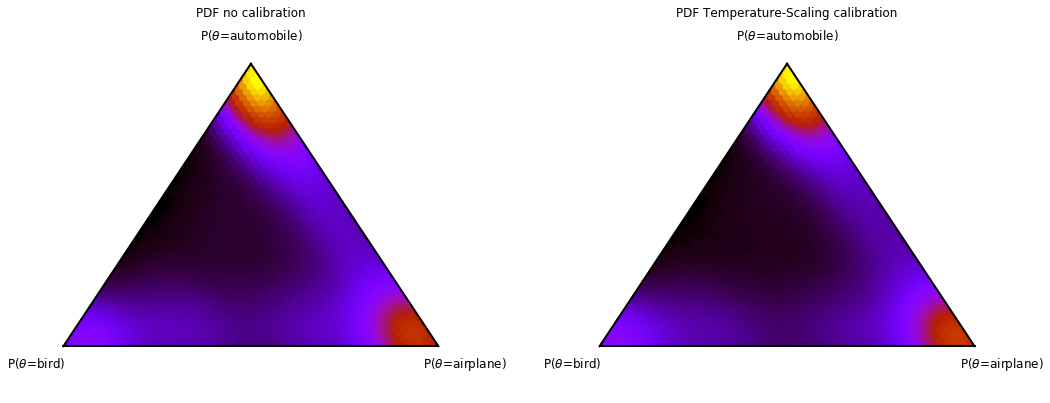

In [14]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_triplex(test_probs, ax=ax_arr[0], title='PDF no calibration', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_triplex(temp_probs, ax=ax_arr[1], title='PDF Temperature-Scaling calibration', fontsize=12, labels=list(ix2label.values()));
plt.show()

### PAV calibration 

In [15]:
t0 = time.time()
pav_cal = PAVCalibrator(logits, target)
print("PAV calibration fitted, elapsed time: {:.3f}s".format(time.time()-t0))

PAV calibration fitted, elapsed time: 0.008s


In [16]:
pav_probs = pav_cal.predict(logits.astype(np.float))

pav_nll = neg_log_likelihood(pav_probs, y_test)
pav_acc = accuracy(pav_probs, y_test)

print("Negative log-likelihood after calibration with temp-scaling: {:.3f}".format(pav_nll))
print("Accuracy after calibration with temp-scaling: {:.3f}".format(pav_acc))

Negative log-likelihood after calibration with temp-scaling: 0.315
Accuracy after calibration with temp-scaling: 0.874


Effects on probability simplex:

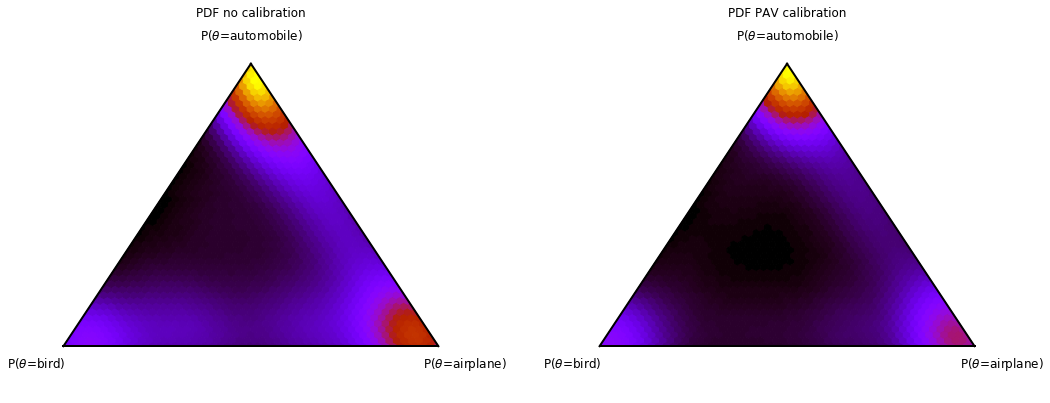

In [17]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_triplex(test_probs, ax=ax_arr[0], title='PDF no calibration', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_triplex(pav_probs, ax=ax_arr[1], title='PDF PAV calibration', fontsize=12, labels=list(ix2label.values()));
plt.show()

### NICE calibration

In [18]:
t0 = time.time()
nice_cal = NiceCalibrator(logits, target, layers=4,
                          hidden_size=[6, 6, 6], epochs=1000, batch_size=100)
print("NICE-flow calibration fitted, elapsed time: {:.3f}s".format(time.time()-t0))

C:\Users\sergi\Anaconda3\envs\famarch\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


NICE-flow calibration fitted, elapsed time: 59.363s


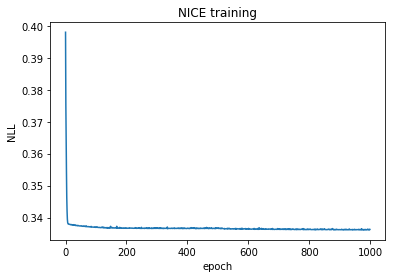

In [19]:
# Visalize training
plt.plot(nice_cal.history.history['loss'])
plt.title('NICE training')
plt.ylabel('NLL')
plt.xlabel('epoch')
plt.show()

In [20]:
nice_probs = nice_cal.predict(logits)

nll_nice = neg_log_likelihood(nice_probs, y_test)
nice_acc = accuracy(nice_probs, y_test)

print("Negative log-likelihood after calibration with NICE: {:.3f}".format(nll_nice))
print("Accuracy after calibration with NICE: {:.3f}".format(nice_acc))

Negative log-likelihood after calibration with NICE: 0.336
Accuracy after calibration with NICE: 0.869


Effects on probability simplex:

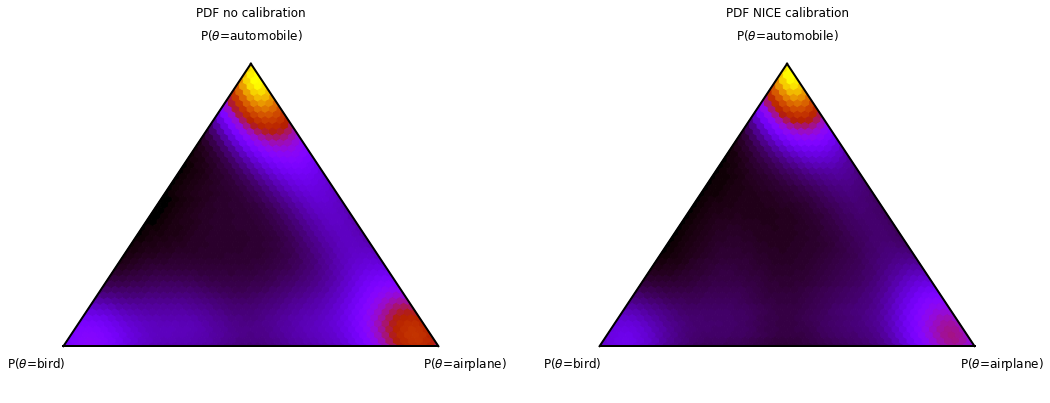

In [21]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_triplex(test_probs, ax=ax_arr[0], title='PDF no calibration', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_triplex(nice_probs, ax=ax_arr[1], title='PDF NICE calibration', fontsize=12, labels=list(ix2label.values()));
plt.show()